# Deep-Q Lunar Lander

## Set up environment and run untrained

In [101]:
import time
import random
import gym
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

In [102]:
from env_video_recorder import EnvVideoRecorder

In [103]:
env = gym.make('LunarLander-v2', render_mode='rgb_array')

In [104]:
rec = EnvVideoRecorder(env)

In [105]:
rec.reset()

(array([-0.0021287 ,  1.4218649 , -0.21562478,  0.48643735,  0.00247338,
         0.04884226,  0.        ,  0.        ], dtype=float32),
 {})

In [106]:
while True:
    rec.render()
    action = 0
    observation, reward, terminated, truncated, info = rec.step(action)
    if terminated:
        break

In [107]:
rec.save('video/dq-0.mp4')

IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (600, 400) to (608, 400) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).


In [108]:
rec.embed_jupyter()

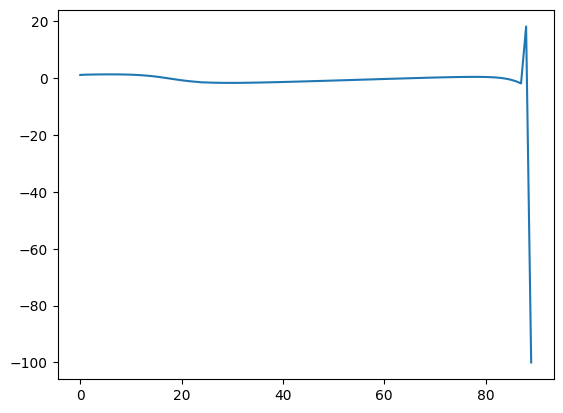

In [109]:
plt.plot(range(len(rec)), rec.rewards())

## Deep Q Learning

In [110]:
BUFFER_SIZE = 100_000
GAMMA = 0.995 # discount factor
ALPHA = 0.001 # learning rate
TAU = 0.001 # soft update factor

STEPS_BETWEEN_LEARNING = 4
MINI_BATCH_SIZE = 64

In [111]:
env = gym.make('LunarLander-v2', render_mode='rgb_array')

In [112]:
state_space_size = env.observation_space.shape
action_space_size = env.action_space.n

In [113]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import MSE

In [114]:
q_net = Sequential([
    Input(state_space_size),
    Dense(64, activation='relu'),
    Dense(64, activation='relu'),
    Dense(action_space_size, activation='linear')
])

In [115]:
target_q_net = Sequential([
    Input(state_space_size),
    Dense(64, activation='relu'),
    Dense(64, activation='relu'),
    Dense(action_space_size, activation='linear')
])

In [116]:
optimizer = Adam(learning_rate=ALPHA)

In [117]:
from collections import namedtuple, deque
experience = namedtuple("Experience", field_names=["state", "action", "reward", "next_state", "done"])

In [118]:
def loss(experiences, gamma, q_net, target_q_net):
    '''
    y_j = R_j if episode terminates at T_{j+1}, else
    y_j = R_j + gamma max_{a'} Q^(s_{j+1}, a')
    '''
    # unpack experiences into its components
    states, actions, rewards, next_states, done_vals = experiences
    
    # compute max Q^(s,a)
    max_qsa = tf.reduce_max(target_q_net(next_states), axis=-1)
    
    # y = R if episode terminates, else y = R + y max Q^(s,a)
    # note: done_vals is boolean, and (1 - done_vals) == 0 if done_vals == True
    y_targets = rewards + (gamma * max_qsa * (1 - done_vals))
    
    q_values = q_net(states)
    # tf.gather_nd(params, indices) returns `indices` slices of `params`
    q_values = tf.gather_nd(q_values, 
                            tf.stack([tf.range(q_values.shape[0]),
                                      tf.cast(actions, tf.int32)],
                                     axis=1
                                    ))
    
    # compute MSE loss
    return MSE(y_targets, q_values)

In [119]:
@tf.function
def learn(experiences, gamma):
    """
    Fit the Q and Q target networks
    """
    
    # compute loss
    with tf.GradientTape() as tape:
        computed_loss = loss(experiences, gamma, q_net, target_q_net)
        
    # update q_net
    gradients = tape.gradient(computed_loss, q_net.trainable_variables)
    optimizer.apply_gradients(zip(gradients, q_net.trainable_variables))
    
    # update target_q_net
    for target_weights, q_net_weights in zip(target_q_net.weights, q_net.weights):
        target_weights.assign(TAU * q_net_weights + (1.0 - TAU) * target_weights)

In [120]:
time_begin = time.time()

episodes = 10_000 # how many times we play the game
max_steps = 1_000 # how many actions allowed before 'time out'

score_history = []

avg_points = 100

epsilon = 1.0 # initial epsilon for greedy policy (exploration/exploitation)
epsilon_decay = 0.985
epsilon_min = 0.01

buffer = deque(maxlen=BUFFER_SIZE)

# clone q_net into target_q_net
target_q_net.set_weights(q_net.get_weights())

for i in range(episodes):
    state, _ = env.reset()
    score = 0
    
    for t in range(max_steps):
        state_qn = np.expand_dims(state, axis=0)
        q_values = q_net(state_qn)
        # make epsilon greedy choice
        if random.random() > epsilon:
            # exploitation
            action = np.argmax(q_values.numpy()[0])
        else:
            # exploration
            action = random.choice(np.arange(4))
        
        # take action and update buffer
        next_state, reward, done, _, _ = env.step(action)
        buffer.append(experience(state, action, reward, next_state, done))
        
        # check whether this is a learning step
        if (t + 1) % STEPS_BETWEEN_LEARNING == 0 and len(buffer) > MINI_BATCH_SIZE:
            # this is a learning step
            experiences = random.sample(buffer, k=MINI_BATCH_SIZE)
            states = tf.convert_to_tensor(
                np.array([e.state for e in experiences if e is not None]),
                dtype=tf.float32)
            actions = tf.convert_to_tensor(
                np.array([e.action for e in experiences if e is not None]), 
                dtype=tf.float32)
            rewards = tf.convert_to_tensor(
                np.array([e.reward for e in experiences if e is not None]), 
                dtype=tf.float32)
            next_states = tf.convert_to_tensor(
                np.array([e.next_state for e in experiences if e is not None]),
                dtype=tf.float32)
            done_vals = tf.convert_to_tensor(
                np.array([e.done for e in experiences if e is not None]).astype(np.uint8),
                dtype=tf.float32)
            experiences = states, actions, rewards, next_states, done_vals
            learn(experiences, GAMMA)
            
        state = next_state.copy()
        score += reward
        
        if done: break
        
    score_history.append(score)
    avg_latest_score = np.mean(score_history[-avg_points:])

    # update epsilon
    epsilon = max(epsilon_min, epsilon * epsilon_decay)

    # display status
    status_message = f'\rEpisode {i + 1} | Total score average of last {avg_points} episodes: {avg_latest_score:.2f}'
    print(status_message, end='')
    if (i + 1) % 100 == 0:
        print(status_message)

    if avg_latest_score >= 200.0:
        print(f"\n\nEnvironment solved in {i+1} episodes!")
        q_net.save('lunar_lander_model.h5')
        break
            
time_end = time.time()
runtime = time_end - time_begin
print(f'\nTotal runtime: {runtime:.2f} sec. ({(runtime/60):.2f} min.)')

Episode 100 | Total score average of last 100 episodes: -160.64
Episode 200 | Total score average of last 100 episodes: -105.01
Episode 300 | Total score average of last 100 episodes: -8.5593
Episode 400 | Total score average of last 100 episodes: 88.13
Episode 496 | Total score average of last 100 episodes: 202.67

Environment solved in 496 episodes!

Total runtime: 666.70 sec. (11.11 min.)


In [121]:
rec = EnvVideoRecorder(env)

In [122]:
rec.reset()

(array([ 2.85243994e-04,  1.41355991e+00,  2.88704187e-02,  1.17326856e-01,
        -3.23661690e-04, -6.53957063e-03,  0.00000000e+00,  0.00000000e+00],
       dtype=float32),
 {})

In [123]:
while True:
    rec.render()
    state = np.expand_dims(state, axis=0)
    q_values = q_net(state)
    action = np.argmax(q_values.numpy()[0])
    state, _, terminated, _, _ = rec.step(action)
    if terminated:
        break

In [124]:
rec.save('video/dq-done.mp4')

IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (600, 400) to (608, 400) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).
